In [177]:
!pip install yfinance

In [178]:
#Importing Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import datetime as dt

In [179]:
from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [180]:
#Importing the stock data for Apple Inc. to train our LSTM model
ticker='GOOG'
data=yf.download(ticker,start="2019-09-01",end="2024-09-01")

[*********************100%***********************]  1 of 1 completed


In [181]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-03,58.851501,59.344501,58.160000,58.419498,58.276382,29598000
2019-09-04,58.835499,59.174000,58.549999,59.070499,58.925789,21378000
2019-09-05,59.576500,60.652000,59.576500,60.569000,60.420616,28162000
2019-09-06,60.406502,60.600750,60.126099,60.246498,60.098907,21442000
2019-09-09,60.200001,61.000000,59.631001,60.220501,60.072975,29438000


In [182]:
data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-08-26,168.154999,169.380005,166.320007,167.929993,167.709229,11990300
2024-08-27,167.610001,168.244995,166.160004,166.380005,166.161270,13718200
2024-08-28,166.779999,167.389999,163.279999,164.500000,164.283737,15208700
2024-08-29,166.059998,167.630005,161.981995,163.399994,163.185181,17133800
2024-08-30,164.220001,165.279999,163.410004,165.110001,164.892944,18498800


In [183]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,112.545861,113.847538,111.399261,112.644974,112.378193,2.787185e+07
std,32.364027,32.588262,32.113503,32.339593,32.278341,1.250835e+07
min,52.825500,53.566002,50.676800,52.831001,52.701576,6.936000e+06
25%,87.107498,88.294439,86.402248,87.079874,86.866547,1.954350e+07
50%,114.291248,116.078499,113.280003,114.699997,114.419006,2.491675e+07
75%,137.615005,138.798878,136.248749,137.538246,137.201305,3.221550e+07
max,191.750000,193.309998,190.619995,192.660004,192.406723,9.779860e+07


In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-09-03 to 2024-08-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


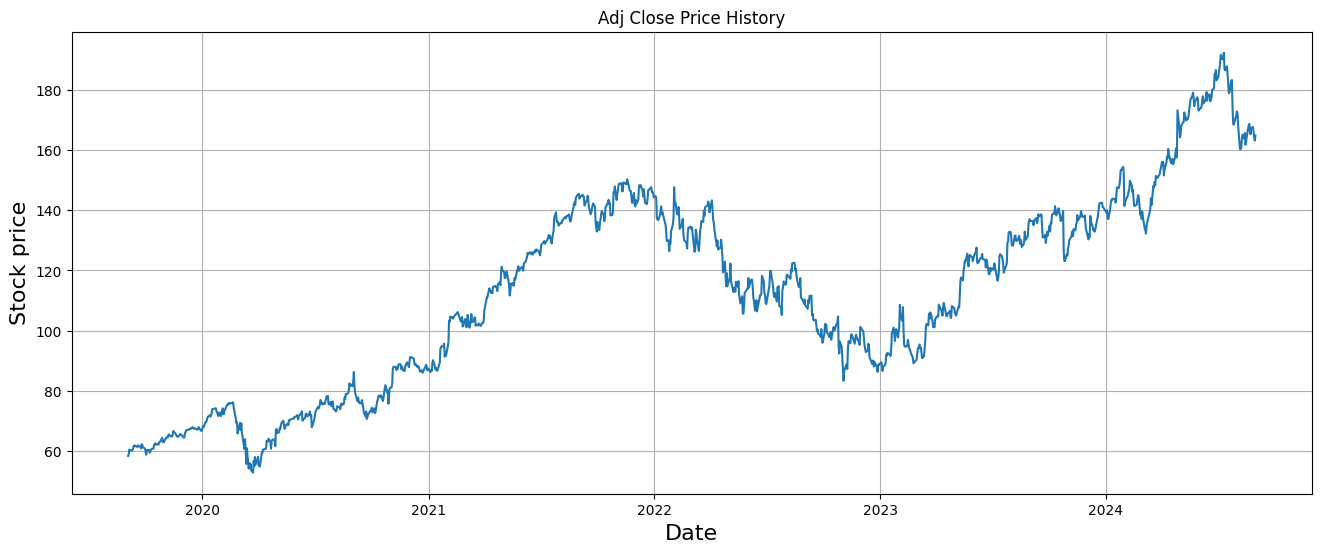

In [185]:
# Plot Adjusted Close price

plt.figure(figsize=(16,6))
plt.title('Adj Close Price History')
plt.plot(data['Adj Close'])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock price', fontsize=16)
plt.grid(True)
plt.show()

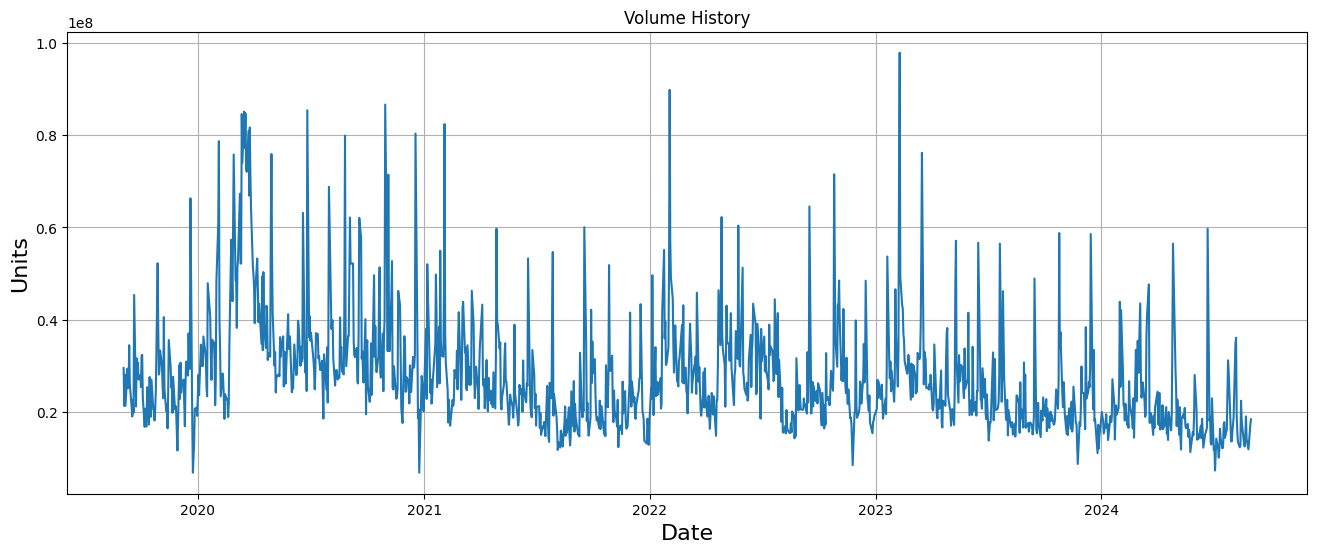

In [186]:
# Plot Volume
plt.figure(figsize=(16,6))
plt.title('Volume History')
plt.plot(data['Volume'])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Units', fontsize=16)
plt.grid(True)
plt.show()

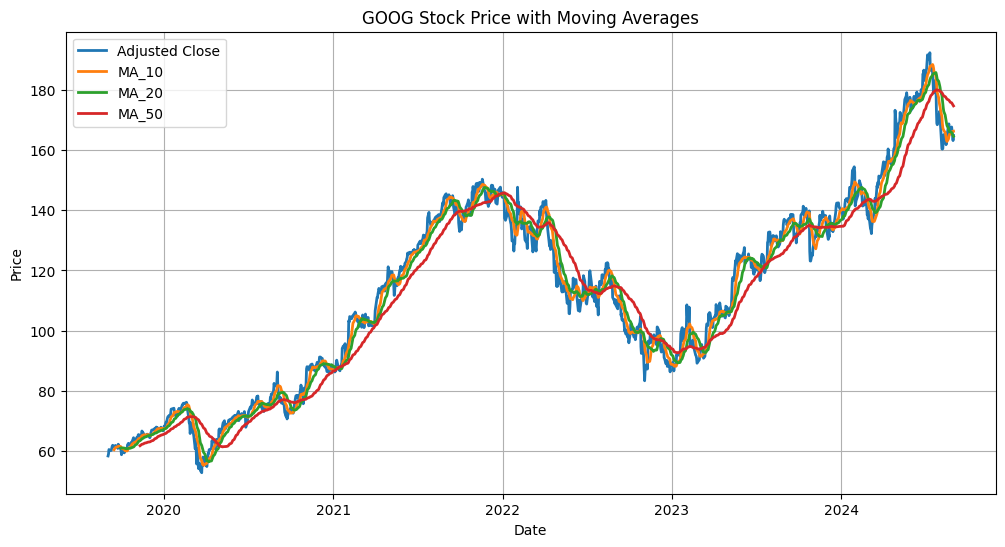

In [187]:
#Plotting the moving average for the past 10,20 and 50 days respectively
moving_avg=[10,20,50]

plt.figure(figsize=(12, 6))
plt.plot(data['Adj Close'], label='Adjusted Close', linewidth=2)

for ma in moving_avg:
  data[f"MA_{ma}"]=data['Adj Close'].rolling(ma).mean()
  plt.plot(data[f"MA_{ma}"], linewidth=2, label=f"MA_{ma}")

plt.title(f'{ticker} Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Data preprocessing for training the model


In [188]:
#we will train using the closing value of the stock price
dataset=data.filter(['Close'])
dataset.head(5)

,Close
Date,
2019-09-03,58.419498
2019-09-04,59.070499
2019-09-05,60.569000
2019-09-06,60.246498
2019-09-09,60.220501


In [189]:
type(dataset)

pandas.core.frame.DataFrame

In [190]:
#forming a numpy array of the closing valyues
dataset=dataset.values
dataset

array([[ 58.41949844],
       [ 59.07049942],
       [ 60.56900024],
       ...,
       [164.5       ],
       [163.3999939 ],
       [165.11000061]])

In [191]:
type(dataset)

numpy.ndarray

In [192]:
dataset.shape

(1258, 1)

In [193]:
datasize=dataset.shape[0]

In [194]:
#Train Test Split
train_len=int(np.ceil(datasize*0.8))
test_len=datasize-train_len
train_len,test_len

(1007, 251)

In [195]:
train_data=dataset[0:train_len,:]

In [196]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(train_data)
scaled_data

array([[0.05709656],
       [0.06374771],
       [0.07905759],
       ...,
       [0.84451057],
       [0.85922263],
       [0.86351383]])

In [197]:
scaled_data.shape

(1007, 1)

In [198]:
#defining the time step for training the data
#means I/P=t1,t2,t3,.....,t100 and O/P=t101
time_step=100

In [199]:
x_train=[]
y_train=[]

for i in range(time_step,train_len):
  x_train.append(scaled_data[i-time_step:i, 0])
  y_train.append(scaled_data[i:i+1, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [200]:
print(x_train.shape), print(y_train.shape)

(907, 100)
(907, 1)


(None, None)

In [201]:
X_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
print(X_train.shape)

(907, 100, 1)


In [202]:
#Creating the LSTM Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 32, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 16, activation='tanh'))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [203]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.1130
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0138
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0133
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0137
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0134
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0111
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0115
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0110
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0112
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0105
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0093
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0092
Epoch 13/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0078
Epoch 14/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0081
Epoch 15/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - lo

In [204]:
model.fit(X_train,y_train,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0025
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0024
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0024
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0025
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022
Epoch 13/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0023
Epoch 14/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0022
Epoch 15/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025
Epoc

In [205]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 100, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 100, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 100, 32)             │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 394,613 (1.51 MB)

 Trainable params: 131,537 (513.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 263,076 (1.00 MB)

In [206]:
test_data=dataset[train_len:, :]

In [207]:
test_data.shape

(251, 1)

In [208]:
test=dataset[len(dataset)-len(test_data)-time_step:]
test=test.reshape(-1,1)
test=scaler.transform(test)

In [209]:
test.shape

(351, 1)

In [210]:
X_test=[]
y_test=dataset[train_len:, :]
for i in range(100,len(test)):
  X_test.append(test[i-100:i, 0])

X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)

(251, 100, 1)


In [211]:
predictions=model.predict(X_test)
predictions=scaler.inverse_transform(predictions)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [212]:
predictions.shape

(251, 1)

In [213]:
# # Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5.592338849260821

<ipython-input-214-d1f6a1922a7b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


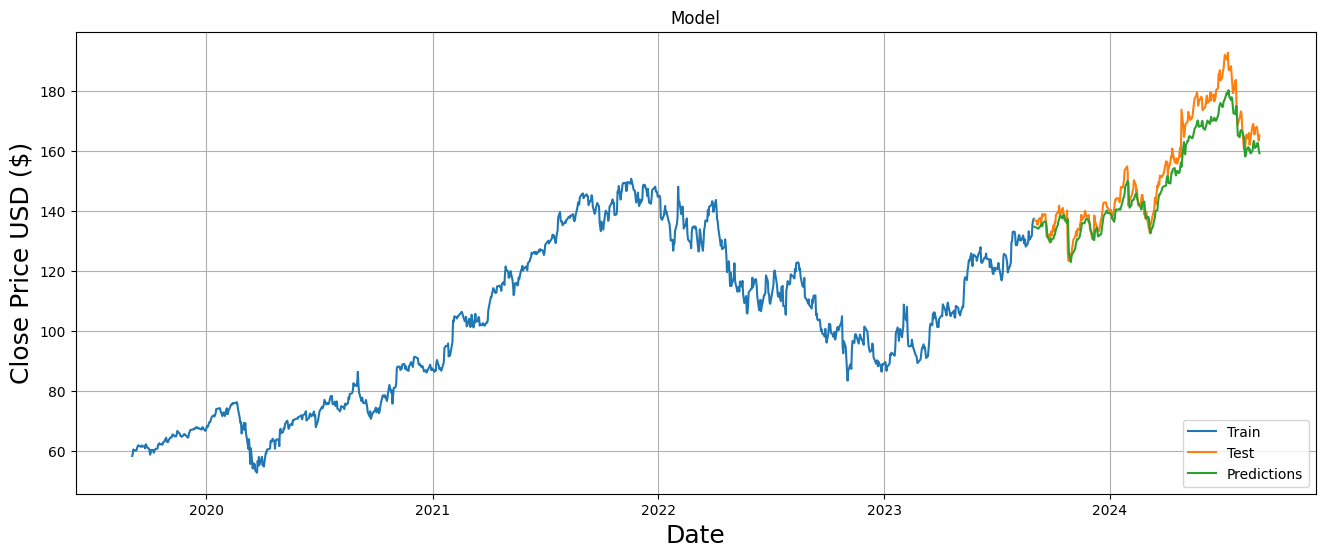

In [214]:
# Plot the data
train = data[:train_len]
test = data[train_len:]
test['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], label='Training')
plt.plot(test['Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.grid(True)
plt.show()

In [215]:
print(test['Close'],test['Predictions'])

Date
2023-09-01    136.800003
2023-09-05    136.710007
2023-09-06    135.369995
2023-09-07    136.199997
2023-09-08    137.199997
                 ...    
2024-08-26    167.929993
2024-08-27    166.380005
2024-08-28    164.500000
2024-08-29    163.399994
2024-08-30    165.110001
Name: Close, Length: 251, dtype: float64 Date
2023-09-01    134.729813
2023-09-05    134.407257
2023-09-06    134.303802
2023-09-07    134.028656
2023-09-08    134.219055
                 ...    
2024-08-26    161.668396
2024-08-27    162.671890
2024-08-28    161.855682
2024-08-29    160.182846
2024-08-30    159.193405
Name: Predictions, Length: 251, dtype: float32


In [216]:
model.save('LSTM.h5')